<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
pip install sklearn-lvq

In [223]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt

In [224]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [225]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [226]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

In [227]:
def print_patrones(list_series,list_categorias,list_patrones,title_,namefile_): 
    cat = np.unique(list_categorias)
    n = math.ceil(pow(n_clusters, 0.5))
    fig, axs = plt.subplots(n, n, figsize=(15,14))
    row=0; col=0
    for c in cat:
        j = 0
        for g in list_categorias:    
            if c == g:
                axs[row,col].plot(list_series[j],alpha=0.5)
                axs[row,col].set_title(title_+str(c))
                #axs[row,col].xaxis.set_xlabel(horas_invierno)
            j = j + 1
        if len(list_patrones) != 0:
            axs[row, col].plot(list_patrones[c],alpha=0.7,color='red',linestyle='dashed',linewidth=4)
        col = col + 1
        if col == n:
            col = 0
            row = row + 1  
    plt.savefig(namefile_, transparent=True)
    plt.show()

# **Leemos datos fotovoltaicos**

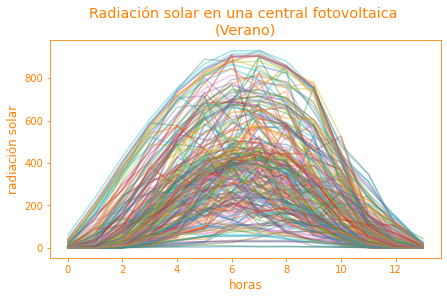

In [280]:
df = pd.read_csv('rg1_horas.csv')

##totales por dia ('SUMA'), diferenciados de primer orden ('dSUMA'), de segundo orden ('ddSUMA')
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

## Por estación del año
df_invierno = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
df_verano   = df[(df.MONTH==5) |(df.MONTH==6) |(df.MONTH==7)|(df.MONTH==8)|(df.MONTH==9)|(df.MONTH==10)]
df = df_invierno
horas_verano   = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
horas_invierno = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_invierno].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.3)

print_serie(X_train,'Radiación solar en una central fotovoltaica \n(Verano)',False,'fig_t13_all')

# **KNN from scratch**


In [ ]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def euclidean(row1, row2):
	  distance = 0.0
	  for i in range(len(row1)-1):
		    distance += (row1[i] - row2[i])**2
	  return sqrt(distance)
   
dataset = [[2.7810836,2.550537003,0],	[1.465489372,2.362125076,0],	[3.396561688,4.400293529,0],	[1.38807019,1.850220317,0],[3.06407232,3.005305973,0],	[7.627531214,2.759262235,1],	[5.332441248,2.088626775,1],	[6.922596716,1.77106367,1],	[8.675418651,-0.242068655,1],[7.673756466,3.508563011,1]]

row0 = dataset[0]
for row in dataset:
	  distance = euclidean(row0, row)
	  print(distance)

In [282]:
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors):
  
    distances = list()

    for train_row in train:
        dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

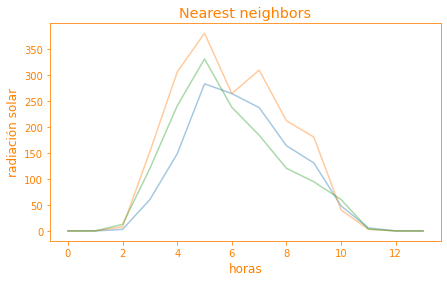

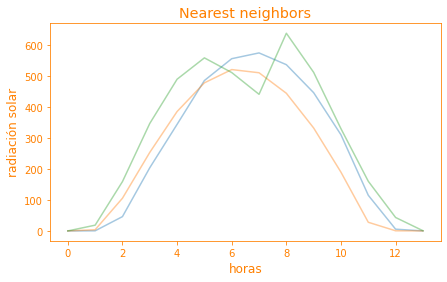

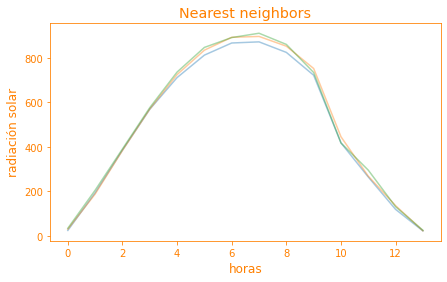

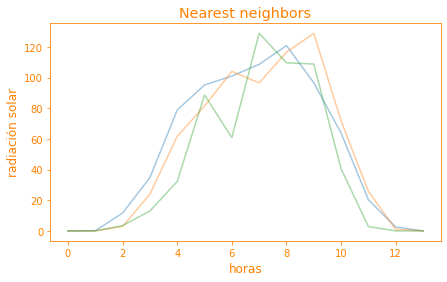

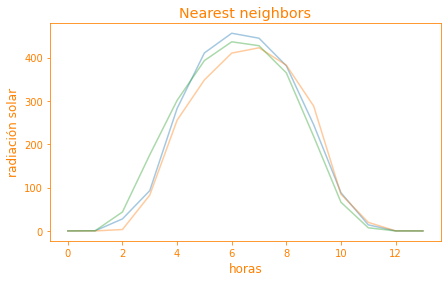

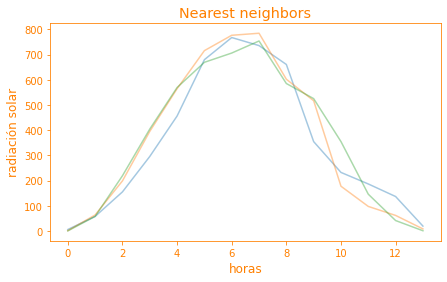

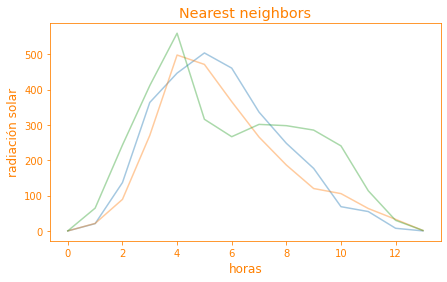

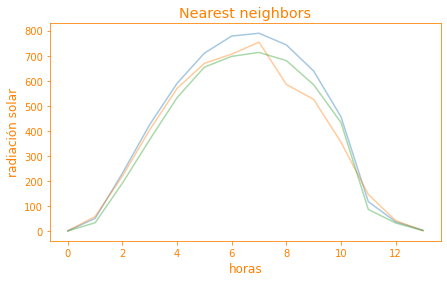

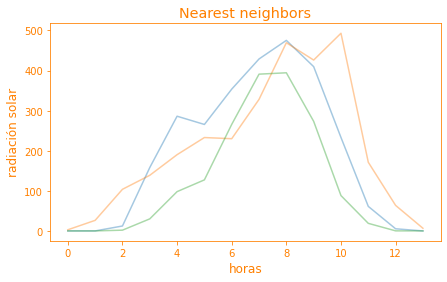

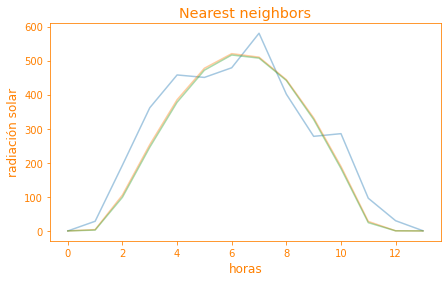

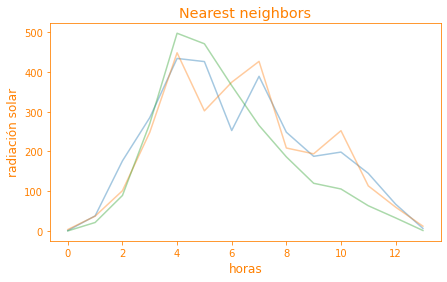

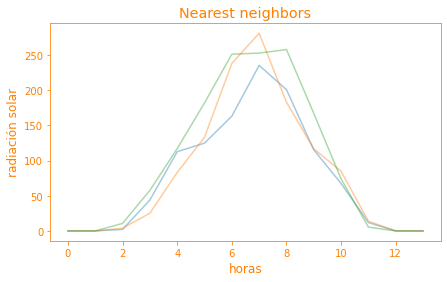

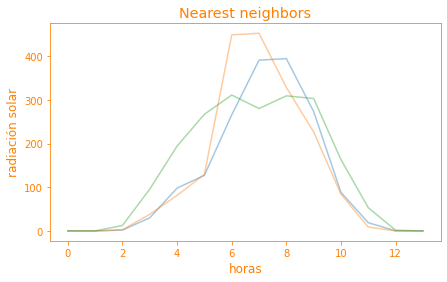

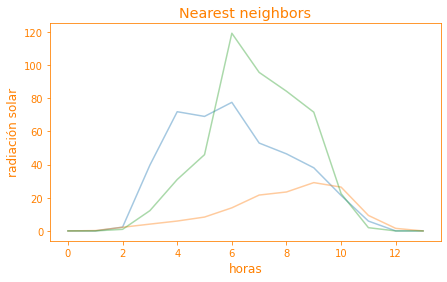

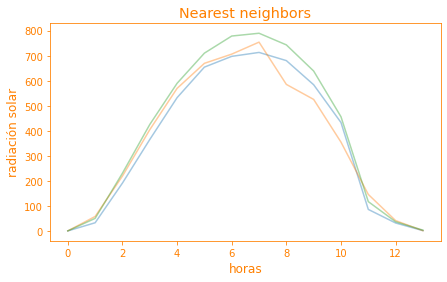

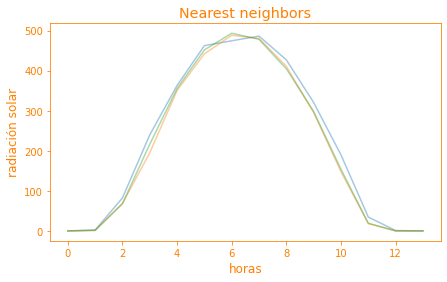

In [287]:
#neighbors = get_neighbors(dataset, dataset[0], 5)
serie = []
for center in centers_:
    neighbors = get_neighbors(X_test, center, 3)
    for neighbor in neighbors:
        serie.append(neighbor)
    print_serie(serie_=serie,title_="Nearest neighbors",dot_=False,namefile_="fig_t13_knn_scratch")
    serie = []
AQUI VOY!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

In [232]:
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

In [ ]:
prediction = predict_classification(dataset, dataset[0], 3)
print('Expected %d, Got %d.' % (dataset[0][-1], prediction))

# **K-means**


y_kmeans [ 8  2  2 13 12 11  3  4 13 12  0 15  4 15 12  4  7 12 15 14 15  3  0  0
  0  2 10  4 14 11 10 12 13  7  0 13 14 10  3  4  1  3 14  4  8 11  3 11
  0 14  5 14 10  3  0  0  7 11 11  5  0 11  4  1 15  3 13 15  3  7  0 11
  1  4  2  8 12  3  4  4  8 11  0  0  7 15  4 15  1  0  0  4 10  4  1  2
  1  4 11 11  5  4  5  2  0  0  0  4]
y_kmeans_train [11  0 14  8  7 13  0 14  3 13 11  3 15  1  8  8  3 12 13 14 11  8 13  3
 13  9  8 11  3  7  2  4  0  9  0 11 15  8  2  0  0  0 15  1  1  8  4 11
 12  3 13  0  0 15 14  1  3 11  8 11  9  5 11 13 11 11  7 12  1 15  2 11
  4 15 11 10 12 13  0 10 15  0 15  4  4 10  1  4  0 14  8 11  2 13 14  0
 11  7  4  0 12  3 14  2 13 13 14  0  4  9  8  3  7 11  0 11  4  1 14  4
  3  9  0 12 15 12  2 12  7 15  9  8  4 12  4  4  4 11  5  4  5  3  3  2
 15  8  4  4 11 11 12 13 11  8 11  0 12 12 11  4 12  3  4 11  0 11 11  3
  0  2  4 15 12 11  0  4  0  4 10 13  0  0 12  9  4  0  0  4  2  7  2  4
 13 14  2  3 15 15  4 14  4  6  1  9 10 15  7 15  1  4  2 10  

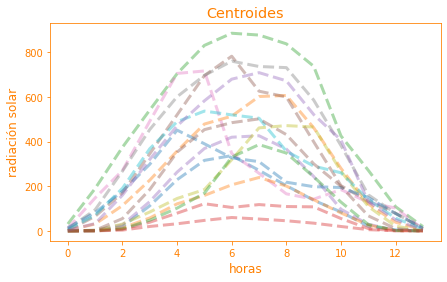

In [234]:
n_clusters = 16
k_means = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans, KMeans
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_kmeans = k_means.predict(X_test)
y_kmeans_train = k_means.predict(X_train)
print('y_kmeans' , y_kmeans)
print('y_kmeans_train' , y_kmeans_train)
print_serie(centers_,'Centroides',True,'fig_t13_centroids')
#scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

X_train (kmeans)


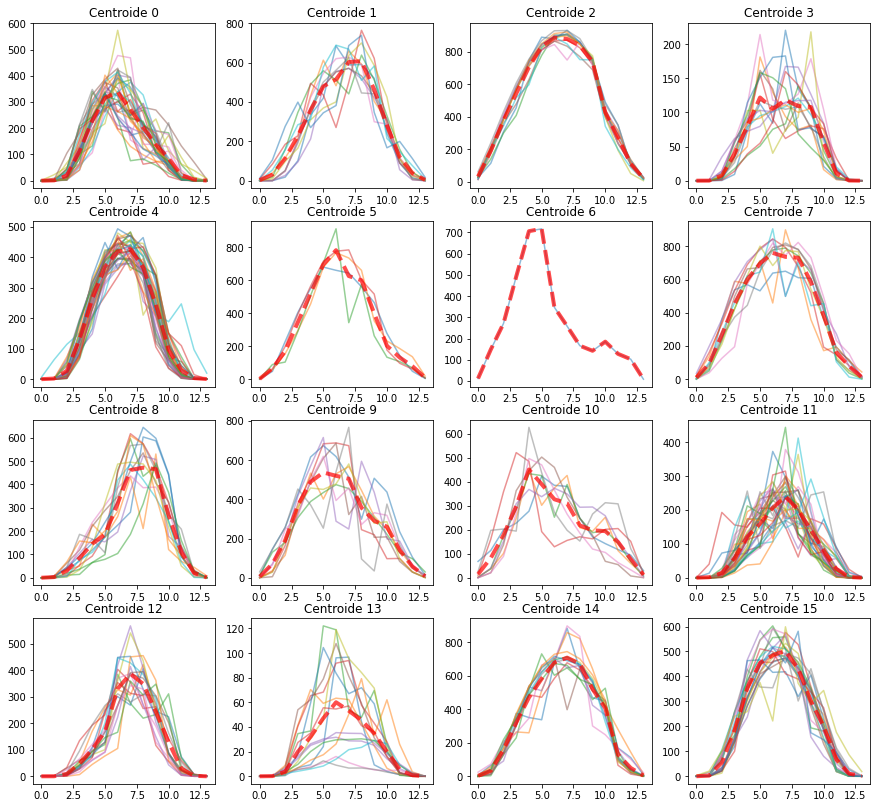

In [235]:
print('X_train (kmeans)')
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

X_test (kmeans)


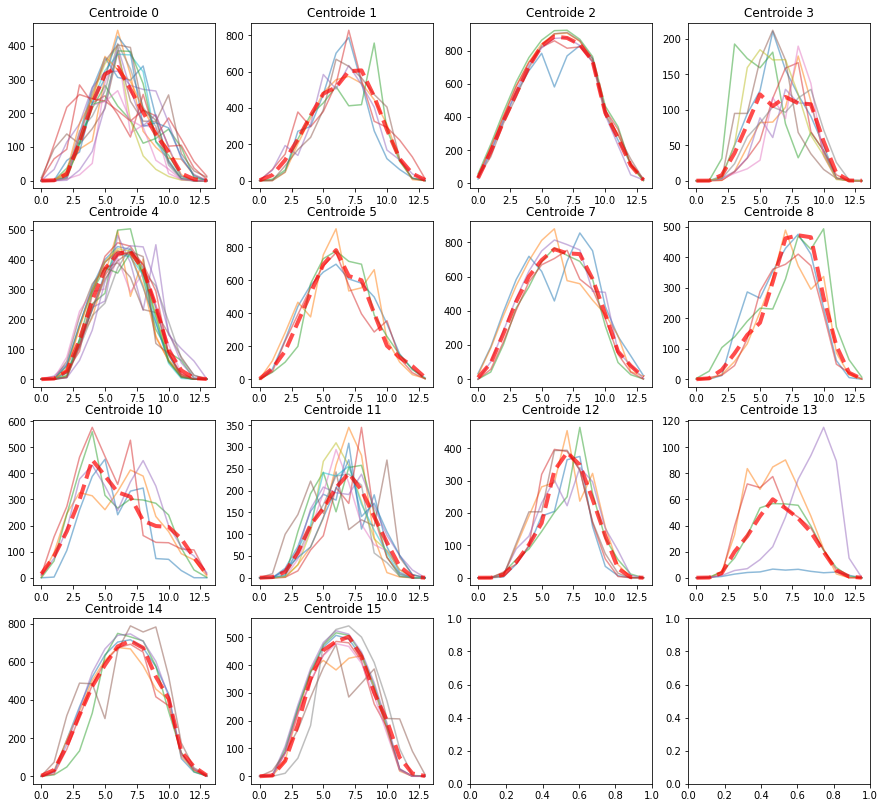

In [236]:
print('X_test (kmeans)')
print_patrones(list_series=X_test,list_categorias=y_kmeans,list_patrones=centers_,title_='Centroide ',namefile_='fig_t13_kmeans_test')

# **LVQ**

In [237]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ')
glvq = GlvqModel(prototypes_per_class=1, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
glvq_pred_train = glvq.predict(X_train)
print('glvq_pred',glvq_pred)
print('glvq_pred_train', glvq_pred_train)
print('classification accuracy:', (glvq.score(X_test, glvq_pred)))
plt.show()

GLVQ
glvq_pred [ 8  2  2 13 12 11 11  4 13 12  4 15  4 15 12  4  7 12 15 14 15  3  0  0
  0  2 10  4 14 11 10 12 13  7  0 13 14 10  3  4  1  3 14 10  8 11  3 11
  0 14  5 14 10 11  0  0  7 11 11  5  0 11  4  1 15  3 13  4  3 14  4 11
  1  4  2  8 12 11  4  4  8 11  0  0  7 15  4  1  1  0 10  4 10  4  1  2
  1  4 11 11  5  4  5  2 11  0  0  4]
glvq_pred_train [11  0 14  8  7 13  0 14  3 13 11  3 15  1  8  8  3 12 13 14 11  8 13  3
 13  9  8 11  3  7  2  4  0  9  0 11 15  8  2  0  0  0 15  1  1  8  4 11
 12  3 13  0  0 15 14  1  3 11  8 11  9  5 11 13 11 11  7 12  1 15  2 11
  4  4 11 10 12 13  4 10 15  4 15  4  4 10  1  4  0 14  8 11  2 13 14  0
 11  7  4  0 12  3  5  2 13 13 14  0  4  9  8  3  7 11  0 11  4  1 14  4
  3  9  0 12 15 12  2 12  7 15  9  8  4 12  4  4  4 11  5  4  5  3  3  2
 15  8  4  4 11 11 12 13 11  8 11  0 12 12 11  4 12  3  4 11  0 11 11  3
 11  2  4 15 12 11  0  4  0  4 10 13  0  0 12  9  4  0  0  4  2 14  2  4
 13 14  2  3 15 15  4 14  4  6  1  9 10 15  7 15  1  4 

X_train (LVQ)


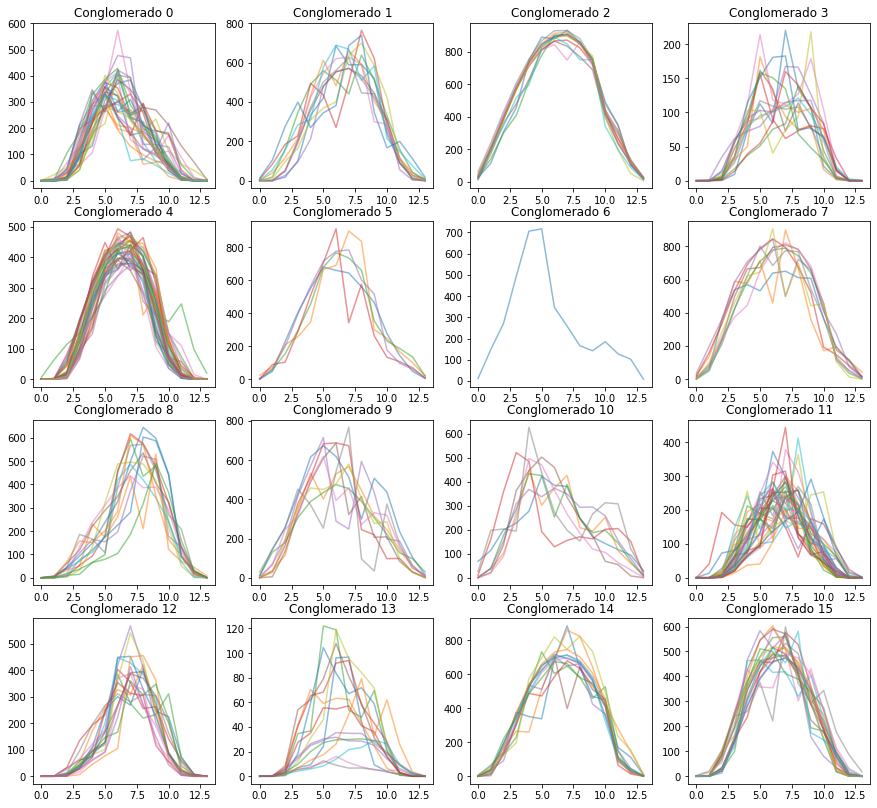

In [238]:
print('X_train (LVQ)')
print_patrones(list_series=X_train,list_categorias=glvq_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_train')

X_test (LVQ)


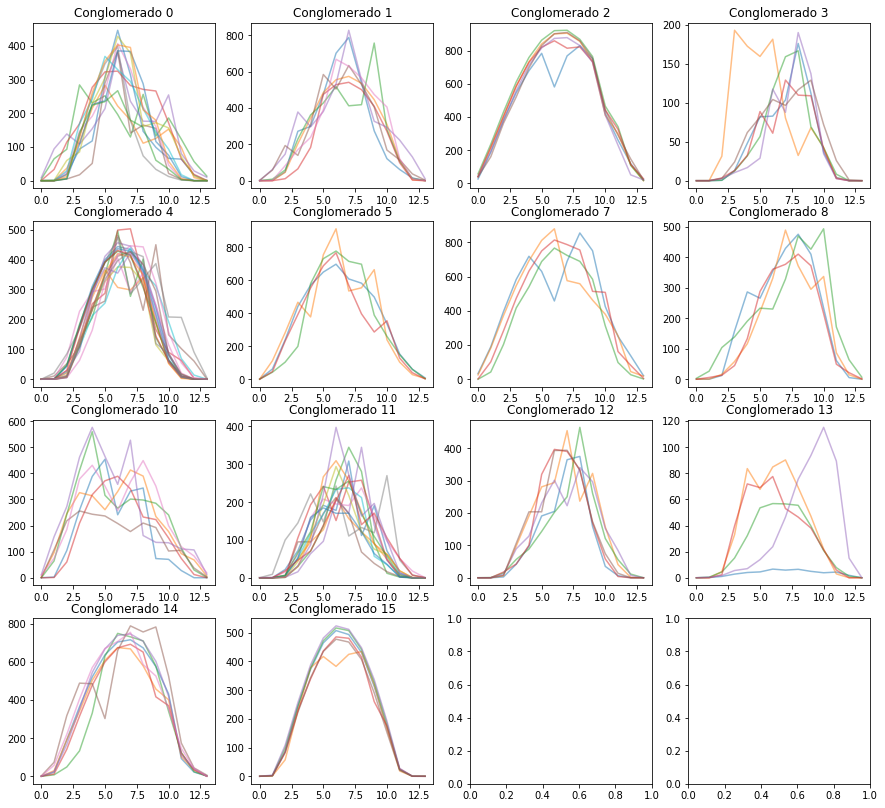

In [239]:
print('X_test (LVQ)')
print_patrones(list_series=X_test,list_categorias=glvq_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_test')

# **GaussianMixture**

In [240]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='full') #full, tied, diag, spherical
gm.fit(X_train)
gm_pred_train = gm.predict(X_train)
gm_pred       = gm.predict(X_test)

print('classification accuracy train:', gm.score(X_train, gm_pred_train))
print('classification accuracy:', gm.score(X_test, gm_pred))

print('gm_pred',gm_pred)
print('gm_pred_train', gm_pred_train)

classification accuracy train: -37.2526665152567
classification accuracy: -224.07413019215198
gm_pred [5 3 3 9 1 5 1 5 9 5 5 5 5 5 5 7 3 5 5 3 5 1 5 7 3 3 5 5 3 1 3 5 9 3 3 9 3
 3 5 3 3 1 3 5 7 1 9 1 3 3 3 3 3 5 1 5 3 7 3 3 5 1 5 3 5 1 3 3 9 3 6 1 3 5
 3 3 5 1 5 6 3 1 5 5 3 5 5 3 3 6 3 6 3 5 3 3 3 5 6 5 3 5 3 3 1 5 6 5]
gm_pred_train [ 1  6  3  8  3  9  6  3  1  9  1  9 10 13  7  8  9  7  9  3  1  8  9  9
  9  3  8  1  9  0  4  5  5  2  6  1  5  8 11  6  7 14  2 13 13 10  5 14
  7  9  9  6 14 13  3 13  9 14  8  1  2  3  1  9  1 14  3  7 13  2  4  1
 10  5  1 15  5  9  6 15  5  6 10  7  5 15 13  5  6  3  8 14 11  9  3  5
  1 11  5  6  7  9  0 11  9  9  3  5  5  2  7  9 11  5  6  1 10 13  3 10
  9  2  5  7  5  7 11  7 11  2  2  8 10  7  5 10 10  1  0  5  2  1  9 11
 10  8  5  5  1 14  7  9  1  7 14  6  7  7 14  6  7  9  5  1  5  1  1  9
  1 11  5  5  1 14  6  5  1  5 12  9  6  6  1 15  6  6  5  5 11  3 11  6
  9  3 11  9  2 10  6  3  6 15 13 15 15  5  3 10 13  6 11 15  6  7  3  3
 14 10 

X_train (GaussianMixture)


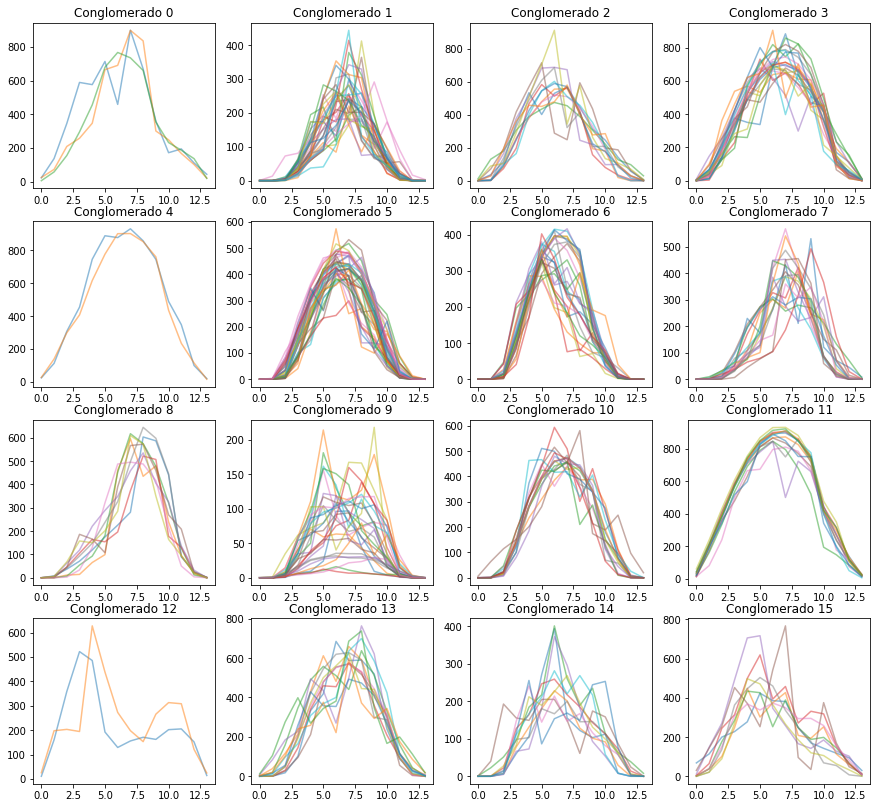

In [241]:
print('X_train (GaussianMixture)')
print_patrones(list_series=X_train,list_categorias=gm_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_train')

X_test (GaussianMixture)


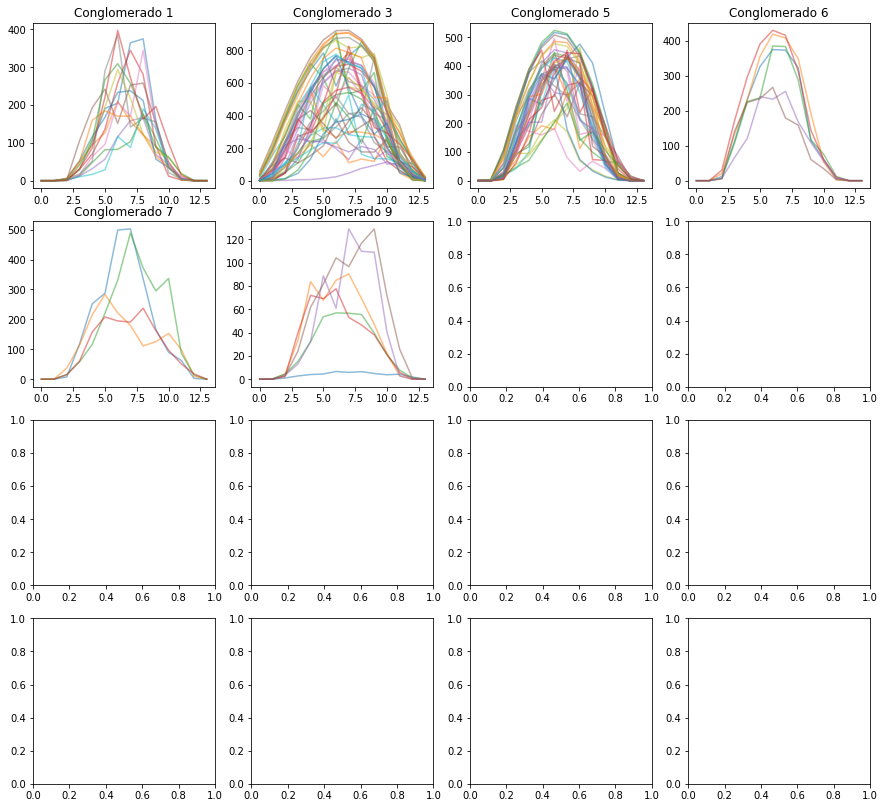

In [242]:
print('X_test (GaussianMixture)')
print_patrones(list_series=X_test,list_categorias=gm_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_test')

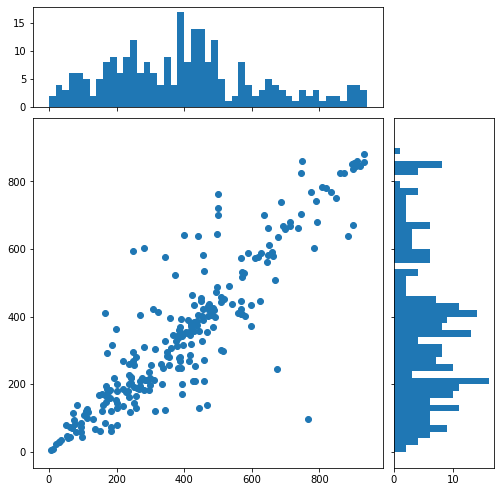

In [243]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.scatter(x, y)
    # now determine nice limits by hand:
    binwidth = 20
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(X_train[:,7],X_train[:,8], ax, ax_histx, ax_histy)

plt.show()

# **KNN**

In [ ]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

In [245]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, labels)
knn_pred_train = knn.predict(X_train)
knn_pred       = knn.predict(X_test)
print('knn_pred', knn_pred)
print('knn_pred_train',knn_pred_train )
print(knn.score(X_test,knn_pred))

knn_pred [ 4  2  2 13 12 11  3  4 13  4  4 15  4  4 12  4  2  0 15 14 15  3  0 11
 11  2  0  4 14 11  4 12 13  7  0 13 14 10  3  4 15  3 14  0 12 11  3 11
 11 14 14 14 10  3 11  0 14 11 11 14  0 11  4  1 15  3 13 15  3 14  4 11
  1  4  2  8  4 11  4  4 12 11  0  0  7  4  4 15  1  4 11  4 15  4  1  2
  1  4 11 11 14  4  9  2  0  4  0  4]
knn_pred_train [11  0 14  8 14 13  0 14  3 13 11  3  4  1 12  8  3 12 13 14 11  8 13  3
 13  9  8 11  3  7  2  4  0 15  0 11 15  8  2  0  0 11 15  1 14  4  4 11
  4  3 13  0  0 15 14  1  3 11  8 11 15 14 11 13 11 11 14 12 15 15  2 11
  4  4 11  4  0 13  4 10 15  4 15  4  4 10  1  4  0 14  4 11  2 13 14  0
 11  2  4  0 12  3 14  2 13 13 14  0  4 15 12  3  2 11  0 11  4 15 14  4
  3  9  0 12 15  0  2  0  2 15 15  8  4 12  4  4  4 11 14  4  5  3  3  2
 15  8  4  4 11 11 12 13 11 12 11  0 12 12 11  4 12  3  4 11  0 11 11  3
  0  2  4  4  0 11  0  4  0  4 10 13  0  0 11  9  4  0  0  4  2 14  2  4
 13 14  2  3 15 15  4 14  4 10 15  9 10  4 14  4  1  4  2  4  

X_train (KNN)


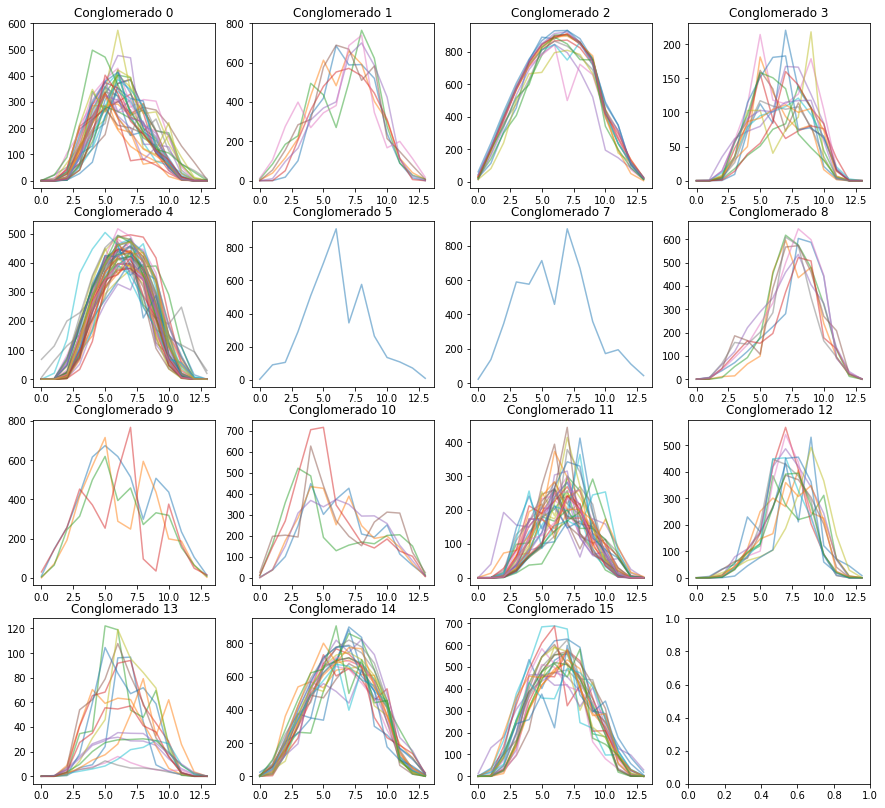

In [246]:
print('X_train (KNN)')
print_patrones(list_series=X_train,list_categorias=knn_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_train')

X_test (KNN)


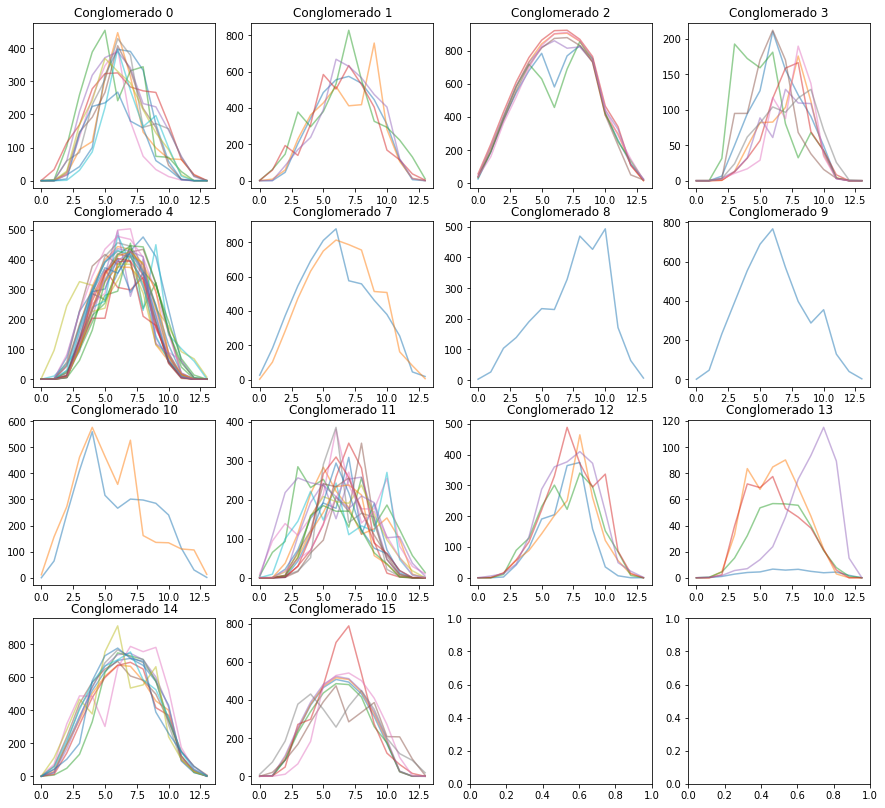

In [247]:
print('X_test (KNN)')
print_patrones(list_series=X_test,list_categorias=knn_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_test')

# **Radiación solar diaria**

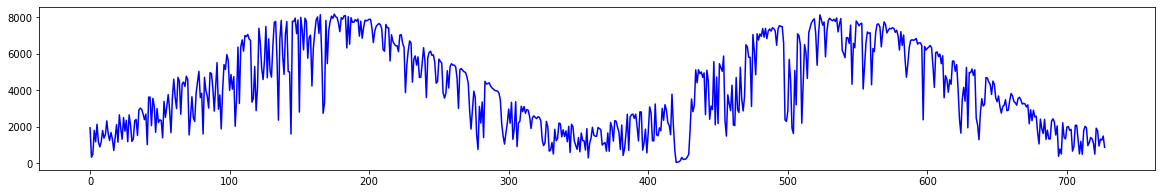

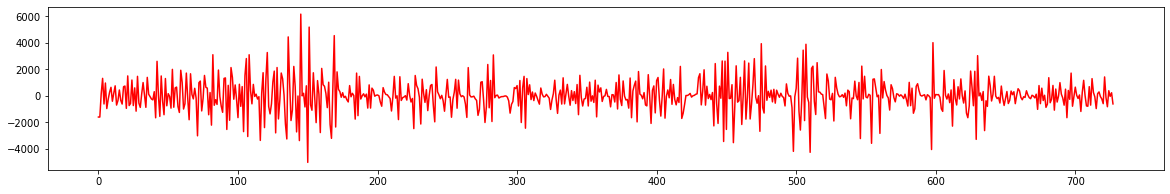

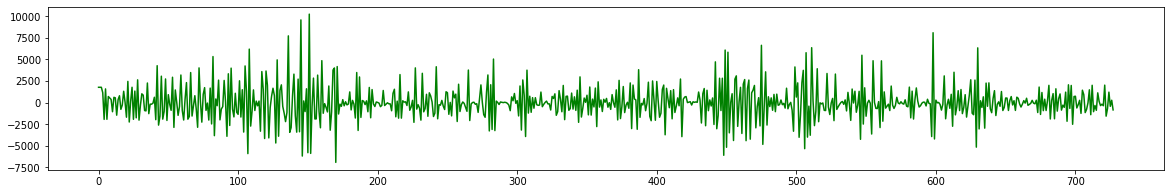

<Figure size 1440x216 with 0 Axes>

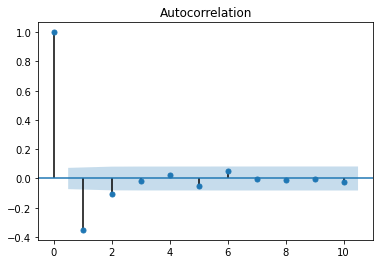

<Figure size 1440x216 with 0 Axes>

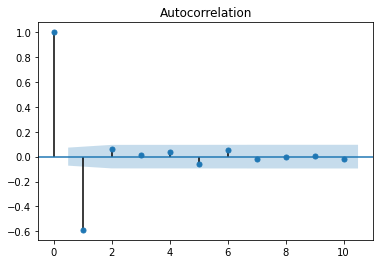

In [248]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=1,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=1,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=1,color='green')
plt.show()

plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()